In [1]:
from multi_nutrient_model import ref_parameters,  I0, sensitivity_analysis, PARAMETER_NAMES
from multi_nutrient_model import perturbation_dynamics, change_parameters, steady_state, I0
import numpy as np
import re

# SOBOL
from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample

# # RSA
# from SALib.analyze.pawn import analyze
# from SALib.sample.latin import sample

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# TODO Better colors for this figure

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['dimgrey', 'indianred'] 



In [3]:
# Scaling 
# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 


In [4]:
# compute sensitivity indices 

SENS_PARAMS  = ["v_energy", "K_i_lipolysis", "K_a_glycolysis",
                "k_glycolysis", "k_lactate", "k_glucose", "k_fatty_acids", "k_3HB", "k_lipolysis", "k_reesterification", 
                "k_ketogenesis", "k_gluconeogenesis",  "K_i_ketogenesis",  "V_glycogenolysis", ]

problem = {
    'groups': SENS_PARAMS,
    'num_vars': len(SENS_PARAMS),
    'names': SENS_PARAMS,
    'bounds': [[0.5, 2],]*len(SENS_PARAMS) ,
    #'dists': [ 'norm',]*len(SENS_PARAMS) ,
}

# Generate samples
X = sample(problem, 2**6, calc_second_order=False)
X.shape

# Select 1000 from the samples
n_samples = 500
np.random.seed(42)
indices = np.random.choice(X.shape[0], n_samples, replace=False)
X_sampled = X[indices]
X_sampled.shape
X = X_sampled

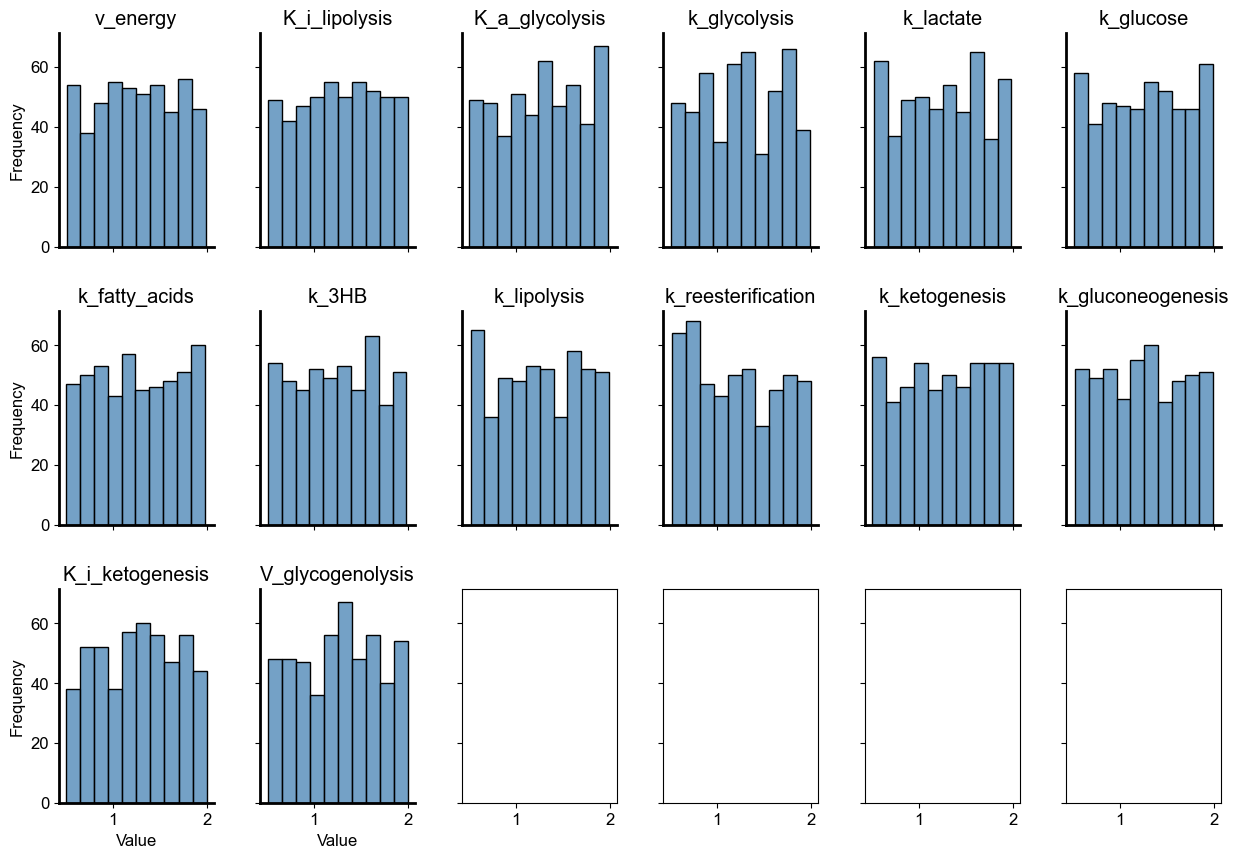

In [5]:
# Plot histogram for each parameter
fig, axes = plt.subplots(3, 6, figsize=(15, 10),
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
axes = axes.flatten()

for i, param in enumerate(SENS_PARAMS):
    ax = axes[i]
    sns.histplot(X[:, i], bins=10, kde=False, ax=ax, color='steelblue')
    ax.set_title(param)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set(**spine_properties)
    ax.spines['bottom'].set(**spine_properties)


In [6]:
def evaluate(param_values):
    Y = []
    for i,log_rel_values in enumerate(param_values):
        p0 = ref_parameters(K_i_ketogenesis=0.2)
        rel_values = 2**log_rel_values
        values = [p0[PARAMETER_NAMES.index(s)] * r for s,r in zip(SENS_PARAMS,rel_values)]
        p = change_parameters(p0, values, ix=SENS_PARAMS)
        X_sol = []
        
        X_0 = steady_state(1, p,)

        x0= X_0.copy()
        for A in np.linspace(1,5,50):
            X = steady_state(A,p,x0=x0,xtol=1e-12)
            X_sol.append(X/X_0)
            x0 = X.copy()
        # IF X_sol contain negative values skip this sample
        if any(np.any(x < 0) for x in X_sol):
            continue
        
        Y.append(X_sol)
        
    return np.array(Y)
    


In [7]:
# Evaluate parameter variations 
Y = evaluate(X)

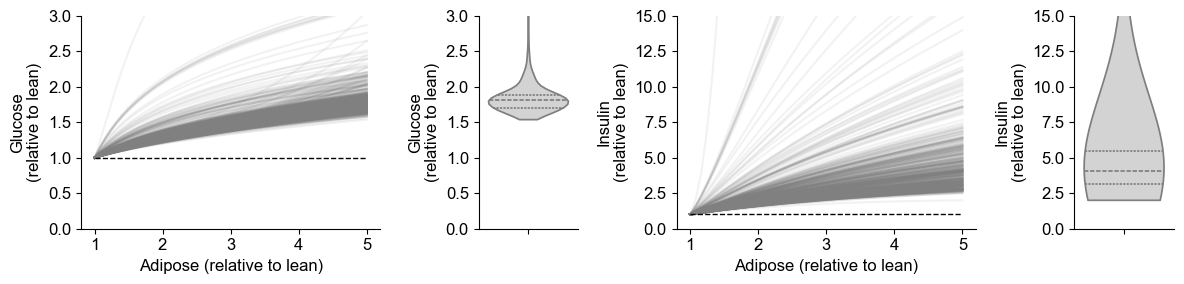

In [8]:
# Plot adiopsoe agains glucose for each parametersets 

# Subplots 
# Left plots larger than right plots
# 1 row, 4 columns
# First two: Adipose vs Glucose (line plot + violin)
# Last two: Adipose vs Insulin (line plot + violin)

fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=False, 
                       gridspec_kw={'width_ratios': [3, 1, 3, 1]})

for i in range(Y.shape[0]):
    ax[0].plot(np.linspace(1,5,50), Y[i,:,1], '-', color='grey', alpha=0.1)
    ax[2].plot(np.linspace(1,5,50), Y[i,:,4], '-', color='grey', alpha=0.1)


# Violin plot in the right side
sns.violinplot(data=Y[:,-1,1], ax=ax[1], color='lightgrey', cut=0, inner='quartile',)
ax[0].set_ylim(0, 3)
ax[1].set_ylim(0, 3)


sns.violinplot(data=Y[:,-1,4], ax=ax[3], color='lightgrey', cut=0, inner='quartile',
native_scale=True, gridsize=1000)

# # Horizontal lines for basal values
ax[0].hlines(1,1,5, color='black', linestyle='--', linewidth=1)
ax[2].hlines(1,1,5, color='black', linestyle='--', linewidth=1)  

ax[2].set_ylim(0, 15)
ax[3].set_ylim(0, 15)    

ax[0].set_ylabel('Glucose\n(relative to lean)')
ax[0].set_xlabel('Adipose (relative to lean)')

ax[2].set_ylabel('Insulin\n(relative to lean)')
ax[2].set_xlabel('Adipose (relative to lean)')

ax[1].set_ylabel('Glucose\n(relative to lean)')
ax[3].set_ylabel('Insulin\n(relative to lean)')

sns.despine()
plt.tight_layout()

plt.savefig('output/robustness_analysis.svg', bbox_inches='tight')